In [505]:
import pandas as pd
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg
from datetime import datetime, date

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import sklearn
from sklearn.model_selection import train_test_split #sklearn import does not automatically install sub packages
from sklearn import linear_model
from statsmodels.stats import outliers_influence

### Function below determines the number of days to reach GDDthreshold. Computes GDDs using input base temperature and daily Tmean array

In [506]:
# Function to compute day on which reach given growth stage.
# Compuate cumulative GDD given input daily GDD_arr
#          Note that this might be GDD, or might be GDD+scaled SR
#          either way, this function doesn't change - is just accumulating and checking against threshold
# Accumulates these and determines the date on which growth stage is met by comparing to GDDthresh
# Outputs S - the number of days to reach  growth stage
def getDaysToStage(GDD_arr,GDDthresh):
    
    # Number of days to get to given growth stage
    S = len(GDD_arr)
    
    # Cumulative GDD variable (will be NGDD)
    NGDD = 0
    
    # Iterate through each day, add to  NGDD
    for d in range(S):
        curr_GDD = GDD_arr[d]
         
        NGDD = NGDD + curr_GDD
                
        if(NGDD > GDDthresh):
            return(d)
    
    # If get here, means we never returned a number, in which case, return nan
    return(np.nan)

### Function uses table with optimal Tupp and associated GDD requirements for each growth stage, calculates the predicted date at which each growth stage would occur using test data and compare with observed data.

In [507]:
# Block does same as block above, but this time making more dynamic -- so can test for 
# different Tbases

## Things we need:
# gdd_thresh_df = Dataframe with needed thresholds for reaching each growth stage.
#               Expects columns: Cultivar	Stage	GDD_Threshold	stage_num
# test_data = growth_pd[growth_pd['test_train']==0].copy()
# wx_data = wxdf_copy()
# run_type = 'from_plant' for runs that have accumulations/tbase to each stage that accrue from plant date, or
#          = 'each' for runs that start from previous stage
# gdd_column = either 'gdd' (if doing just cumulative GDD60) or 'gdd+srad' (if doing cumulative [GDD60+SR])
def getPredObs_DaysToStage(gdd_thresh_df,test_data,wx_data,run_type,gdd_column):

    test_data.set_index(['loc_id','cultivar','plot'],inplace=True)

    # Output 
    vald_arr = []

    # Iterate through each location-cultivar-plot
    for i in set(test_data.index):
        curr_growth = test_data.loc[i].copy()

        # Current loc_id
        curr_loc = list(i)[0]

        # Current cultivar
        curr_cult = list(i)[1]

        # Current plot:
        curr_plot = list(i)[2]


        # Get weather data associated with this location (will be used for all plots at this location)
        curr_wx = wx_data[wx_data['loc_id']==curr_loc]

        # Get plant date
        plant_day_of_year = curr_growth[curr_growth['stage_num']==1]['day_of_year_stage'].values[0] - \
                            curr_growth[curr_growth['stage_num']==1]['elapse_days'].values[0]

        # Iterate through stages (use stage_num, since is numeric); (loop ends at 7 -- means will evaluate 1-6)
        for s in range(1,7):

            # Get date of current stage, if exists
            stage_day = curr_growth[curr_growth['stage_num']==s]['day_of_year_stage'].values
            if len(stage_day) > 0:
                stage_day_of_year = stage_day[0]
            else:
                stage_day_of_year = np.nan

                
            # If doing from Plant Date:
            if run_type=='from_plant':
                
                
                # Number of accumulated GDD to reach stage
                curr_ngdd = gdd_thresh_df[(gdd_thresh_df['cultivar']==curr_cult) &
                                                  (gdd_thresh_df['stage_num']==s)]['seas_to_date_thresh'].values[0]
                
                # Create df with just growing season data, compute GDD using tbase, then cumusm and compare to gdd reqs
                wx_plot = curr_wx[curr_wx['date']>=plant_day_of_year].copy()

                # Call function to calculate the number of days to rech stage (is based on Tmean array)
                pred_ndays_stage = getDaysToStage(np.array(wx_plot[gdd_column]),curr_ngdd)

                #print(s,curr_ngdd,pred_ndays_stage)

                # Then compute the day of year that this is by adding the plant day of year:
                pred_stage_day_of_year = plant_day_of_year + pred_ndays_stage

                vald_arr.append({'cultivar':curr_cult,'stage_num':s,'loc_id':curr_loc,'plot':curr_plot,
                                'Pred_Day_Yr':pred_stage_day_of_year,'Obs_Day_Yr':stage_day_of_year,
                                'Obs-Pred':(stage_day_of_year - pred_stage_day_of_year)})

            # Else, doing for each growth stage
            else:
                # Number of accumulated GDD to reach stage
                curr_ngdd = gdd_thresh_df[(gdd_thresh_df['cultivar']==curr_cult) &
                                                  (gdd_thresh_df['stage_num']==s)]['stage_only_thresh'].values[0]
                
                # Get the day of year for the previous growth stage:
                prev_day_year = np.nan
                if s==1:
                    prev_day_year = plant_day_of_year-1
                else:
                    prev_arr = curr_growth[curr_growth['stage_num']==s-1]['day_of_year_stage'].values
                    if len(prev_arr)>0:
                        prev_day_year = prev_arr[0]
                
                # If we have both this stage's date AND the last stage's date, we can compute
                if (math.isnan(prev_day_year)==False) & (math.isnan(stage_day_of_year)==False):
                    
                    wx_plot = curr_wx[(curr_wx['date']>prev_day_year)]
                                         
                    # Call function to calculate the number of days to reach stage (is based on Tmean array)
                    pred_ndays_stage = getDaysToStage(np.array(wx_plot[gdd_column]),curr_ngdd)

                    # Observed Days this stage:
                    obs_ndays_stage = curr_growth[curr_growth['stage_num']==s]['days_this_stage'].values[0]
                    
                    # Then compute the day of year that this is by adding the plant day of year:
                    pred_stage_day_of_year = plant_day_of_year + pred_ndays_stage

                    vald_arr.append({'cultivar':curr_cult,'stage_num':s,'loc_id':curr_loc,'plot':curr_plot,
                                    'Pred_Days':pred_ndays_stage,'Obs_Days':obs_ndays_stage,
                                    'Obs-Pred':(obs_ndays_stage - pred_ndays_stage)})            
            
    return(pd.DataFrame(vald_arr))

# Read in Growth Stage and Meteorological Data

In [508]:
## Read in Cotton location metadata
# This is from a .csv file that I generated -- based on the tab "location_data" in Maturity_2018_2019.xlsx
# Added a row: LA_2019 (loc_9) because there is a LA_2019 data tab/row in the the spreadsheet. Assuming that
#              the location information for LA_2019 is identical to that of LA_2018 (loc_8)

# Metadata
meta_pd = pd.read_csv(open('CottonDataFiles/stations.csv', 
                             'rb'), 
                        dtype={'Year': float, 'State': str, 
                               'City': str, 'Latitude': float, 
                               'Longitude': float, 'State2':str,'loc_year':str,'loc_id':str})  


In [509]:
# OTHERWISE, READ IN THE GRIDMET DATA THAT WE'VE ALREADY OBTAINED
gridmet_in = pd.read_csv('MetDataFiles/GridMET_forAnalysis_2018_2019.csv')
df_gridmet = gridmet_in.pivot(index=['loc_id','latitude','longitude','year','date'],
                    columns=['VarName'])
df_gridmet.reset_index(inplace=True)

In [510]:
# Convert Tmax and Tmin from Kelvin to Fahrenheit (precip is is scaled to units mm)
# These come from NetCDF files
scale_factor = 0.1
offset_min = 210.0
offset_max = 220.0

df_gridmet['tmmn_C'] = ((df_gridmet['Value']['tmmn'] * scale_factor + offset_min))- 273.15
df_gridmet['tmmx_C'] = ((df_gridmet['Value']['tmmx'] * scale_factor + offset_max))- 273.15
df_gridmet['tmmn_F'] = df_gridmet['tmmn_C'] * (9/5) + 32
df_gridmet['tmmx_F'] = df_gridmet['tmmx_C'] * (9/5) + 32
df_gridmet['tmean_F'] = (df_gridmet['tmmx_F'] + df_gridmet['tmmn_F'])/2

df_gridmet['pr_scaled'] = df_gridmet['Value']['pr'] * scale_factor

# Now also scale Solar Radiation (to units: W m-2)
df_gridmet['srad'] = df_gridmet['Value']['srad'] * scale_factor


# Organize column headings (is currently a multiindex, flattening this)
df_gridmet.columns = [''.join(col) for col in df_gridmet.columns.values]

# Drop the unscaled, raw data from the dataframe(but retain the values in deg C, deg F, and mm)
df_gridmet.drop(columns=['Valuepr','Valuesrad','Valuetmmn','Valuetmmx'],inplace=True)

# Get  Growth Data
### Then compute number of Days Between Each Growth Stage

In [511]:
# Actual Cotton Growth Stage Data
growth_pd = pd.read_excel(open('CottonDataFiles/Maturity_2018_2019.xlsx', 
                               'rb'), sheet_name='combined_18_19',
                          header=0, usecols = "A,B,D,E,F,G,H,I,J",
                          dtype={'location': str, 'year':int, 'plot': int, 
                                 'cultivar': str, 'loc_year':str, 'loc_var': str, 
                                 'growth stage': str, 'date': str,
                                 'plant_date':str})
growth_pd.dropna(inplace=True)

In [512]:
# Updating (fixing?) Cultivar DP 1851 B2XF to DP 1851 B3XF
growth_pd.loc[growth_pd['cultivar']=='DP 1851 B2XF','cultivar'] = 'DP 1851 B3XF'

In [513]:
loc_id_arr = meta_pd['loc_id'].tolist()

# Add loc_id column, matching from meta_pd dataframe, to growth_pd dataframe
growth_pd['loc_id'] = ''
for i in range(len(loc_id_arr)):
    loc_yr_id = meta_pd[meta_pd['loc_id'] == loc_id_arr[i]]['loc_year'].values[0]
    growth_pd.loc[(growth_pd['loc_year']==loc_yr_id) ,'loc_id'] = loc_id_arr[i]
    
    
growth_pd['date'] = pd.to_datetime(growth_pd['date'], errors='coerce')
growth_pd['plant'] = pd.to_datetime(growth_pd['plant'], errors='coerce')

# Sort everything
growth_pd.sort_values(by=['loc_id','plot','date'],inplace=True)

# Compute the number of elapsed days from plant date to a given growth stage
growth_pd['elapse_days'] = (growth_pd['date']-growth_pd['plant']).dt.days

# Compute the day of year for given growth stage (to make it easier to grab from weather dataframe)
growth_pd['jan1'] = pd.to_datetime(growth_pd['year'].astype(str)+'-1-1')
growth_pd['day_of_year_stage'] = (growth_pd['date'] - growth_pd['jan1']).dt.days
growth_pd.drop(columns='jan1',inplace=True)

In [514]:
# Create a numeric column for stages = called stage num
all_stages_order = ['emerge','square','flower','cutout','cracked','60open']
stage_dict = {'emerge':1,'square':2,'flower':3,'cutout':4,'cracked':5,'60open':6}
growth_pd['stage_num'] = growth_pd['growth stage'].map(stage_dict)

In [515]:
growth_pd.set_index(['loc_id','cultivar','plot'],inplace=True)
growth_pd.sort_index(inplace=True)

In [516]:
# Compute difference (just number of days to get from previous stage to current stage)
growth_pd['diff_days'] = growth_pd['elapse_days']
growth_pd['days_this_stage'] = pd.DataFrame(growth_pd['diff_days'].diff()).reset_index().diff_days.values

# All values for 'emerge' will be NaN, so update with the correct val = elapsed days from plant date to emergence
growth_pd.reset_index(inplace=True)
growth_pd.loc[growth_pd['growth stage']=='emerge','days_this_stage'] = growth_pd['elapse_days']

# Drop the temporary column 'diff_days'
growth_pd.drop(columns=['diff_days'],inplace=True)

In [517]:
# There are some duplicate entries for certain stages -- drop these, keeping the first:
growth_pd.drop_duplicates(subset=['loc_id','cultivar','plot','growth stage'],keep='first',inplace=True)

# Which Temperature Dataset to use? 
Set to gridMET here (assign wxdf to appropriate dataframe)


In [518]:
wxdf = df_gridmet.copy() # gridMET
#wxdf = df_prism.copy() # PRISM

## Separate TRAINING and TEST Sets Based on Year

In [519]:
# Training set = 1; Test set = 0
growth_pd['test_train'] = 0
growth_pd.loc[growth_pd['year']==2018,'test_train'] = 1


# Here is where will write a cells to examine whether solar radiation can be a predictor for growth stage

- Will use Tbase = 60
- Will use no upper temperature threshold
- Assuming that function for development is now a GDD+SR hybrid, e.g., sum[max(tmean,tbase) - tbase] + sr_factor
    -- where sr_factor = f(sr)

In [520]:
stages_all = ['emerge','square','flower','cutout','cracked','60open']

In [521]:
wxdf_copy = wxdf.copy().reset_index()
tbase = 60

# Compute daily GDD
wxdf_copy['gdd'] = 0
wxdf_copy.loc[wxdf_copy['tmean_F']>tbase,'gdd'] = wxdf_copy['tmean_F'] - tbase

In [522]:
# Compute cumulative sum GDD by each location (i.e., each site-year)
wxdf_copy['gdd_cum'] = wxdf_copy.groupby('loc_id')['gdd'].cumsum()

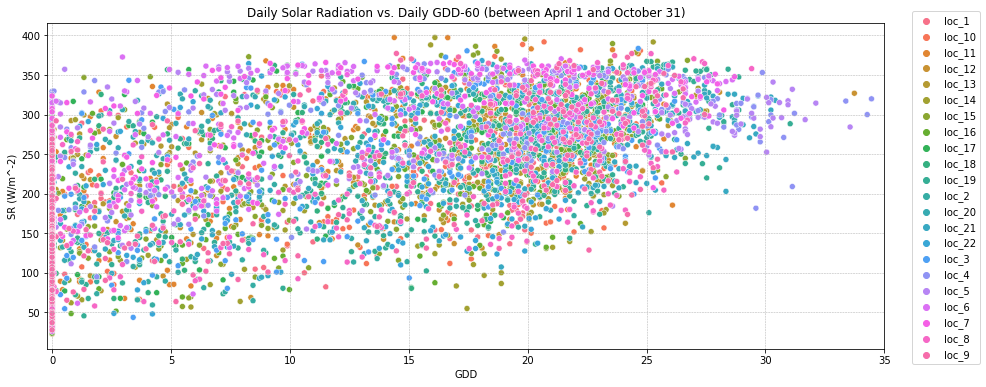

r= 0.6913219629508657 p= 0.0


In [523]:
# Plot Solar radiation and GDD together
stage_tupp_opt = []

fig,ax = plt.subplots(1,figsize=(15,6))

sns.scatterplot(x='gdd',y='srad',hue='loc_id',
              data=wxdf_copy[(wxdf_copy['date']>90) & wxdf_copy['date']<304],ax=ax)
ax.set_title("Daily Solar Radiation vs. Daily GDD-60 (between April 1 and October 31)")

ax.set_ylabel("SR (W/m^-2)")
ax.legend(bbox_to_anchor=(0.62, 0.15, 0.5, 0.9))
ax.set_xlabel("GDD")
plt.xlim([-0.2,35])

plt.grid(linestyle='--',linewidth=0.5)

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(
    wxdf_copy[(wxdf_copy['date']>90) & wxdf_copy['date']<304]['gdd'],
    wxdf_copy[(wxdf_copy['date']>90) & wxdf_copy['date']<304]['srad'])

plt.show()

print('r=',r_value,'p=',p_value)


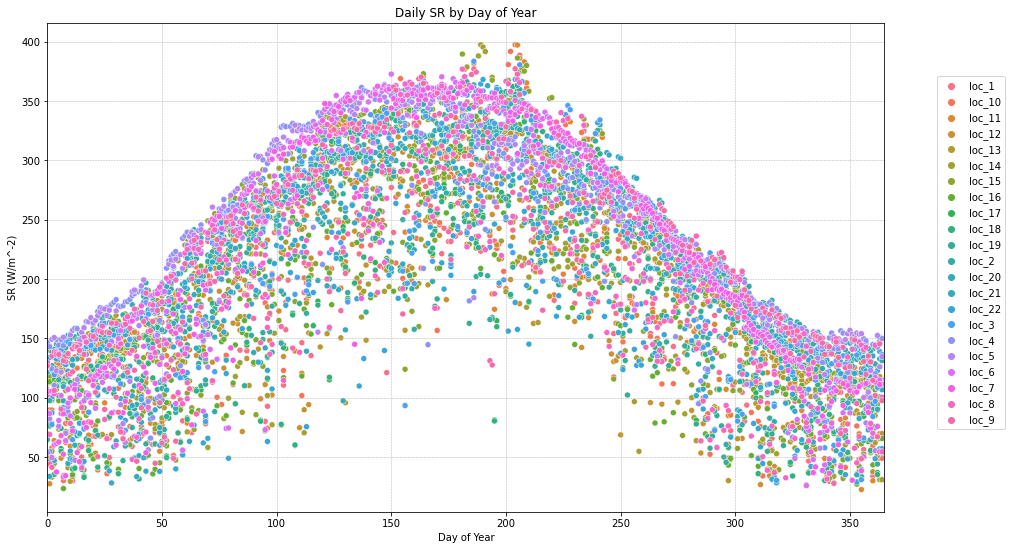

In [524]:
fig,ax = plt.subplots(1,figsize=(15,9))

sns.scatterplot(x='date',y='srad',hue='loc_id',data=wxdf_copy,ax=ax)

ax.set_title("Daily SR by Day of Year")
ax.set_ylabel("SR (W/m^-2)")
ax.legend(bbox_to_anchor=(0.65, 0, 0.5, 0.9))
ax.set_xlabel("Day of Year")
plt.xlim([0,365])

plt.grid(linestyle='--',linewidth=0.5)
plt.show()

In [525]:
# Compute cumulative SR by each location (i.e., each site-year)
wxdf_copy['sr_cum'] = wxdf_copy.groupby('loc_id')['srad'].cumsum()

# Get the daily sum of GDD+scaled SR:
wxdf_copy['gdd+sr'] = wxdf_copy['gdd']+(wxdf_copy['srad']/100)

# Compute cumulative sum GDD+scaled SR by each location (i.e., each site-year)
wxdf_copy['gdd+sr_cum'] = wxdf_copy.groupby('loc_id')['gdd+sr'].cumsum()


In [526]:
# There are some duplicate entries for certain stages -- drop these, keeping the first:
growth_pd.drop_duplicates(subset=['loc_id','cultivar','plot','growth stage'],keep='first',inplace=True)

In [527]:
growth_pd.set_index(['loc_id','cultivar','plot'],inplace=True)

In [528]:
# Add two columns to store total cumulative gdd needed for whole season (gdd_cum_needed) and 
# total gdd needed for just give stage from previous stage (gdd_stage_needed)
growth_pd['gdd_cum_needed'] = np.nan
growth_pd['gdd_stage_needed'] = np.nan

# Add two columns for total solar radiation to reach  growth stage from plant date and from previous stage
growth_pd['srad_seas_to_date'] = np.nan
growth_pd['srad_stage_only'] = np.nan

# Finally, add two columns for combined GDD and total solar radiation to reach growth stage from plant 
# date and from previous stage
growth_pd['gdd+srad_seas_to_date'] = np.nan
growth_pd['gdd+srad_stage_only'] = np.nan

for i in set(growth_pd.index):
    
    # Create a local copy of the growth_pd
    copy_growth = growth_pd.loc[i].copy()
    # Get start and end dates corresponding to this location's (loc_id-cultivar-plot) plant date and harvest (60open)
    plant_day = copy_growth[copy_growth['growth stage']=='emerge']['day_of_year_stage'].values[0] - \
                copy_growth[copy_growth['growth stage']=='emerge']['elapse_days'].values[0]
    last_day = copy_growth.day_of_year_stage.max()
    
    # Get weather data corresponding to just this location-plot 
    gdd_df = wxdf_copy[(wxdf_copy['loc_id']==list(i)[0]) & 
                                  (wxdf_copy['date']>=plant_day) &
                                  (wxdf_copy['date']<=last_day)].copy()
    
    # Get the cumulative gdd correspnding to each growth stage
    days_stages = copy_growth['day_of_year_stage'].values    
    cum_gdd_stages = gdd_df[gdd_df['date'].isin(days_stages)]['gdd_cum'].values
    
    # Now get number gdd for each stage (not cumulative for whole season):
    gdd_each_stage = pd.DataFrame(cum_gdd_stages).diff()
    gdd_each_stage[0].iloc[0] = cum_gdd_stages[0]
    gdd_each_stage = gdd_each_stage.values

    # Adjusting this now: will be cumulative gdd + srad
    # Get the cumulative gdd correspnding to each growth stage
    cum_gdd_sr_stages = gdd_df[gdd_df['date'].isin(days_stages)]['gdd+sr_cum'].values
    
    # Now get number gdd for each stage (not cumulative for whole season):
    gdd_sr_each_stage = pd.DataFrame(cum_gdd_sr_stages).diff()
    gdd_sr_each_stage[0].iloc[0] = cum_gdd_sr_stages[0]
    gdd_sr_each_stage = gdd_sr_each_stage.values

    # Get the mean solar radiation corresponding to each growth stage from plant date
    srad_stage = []
    srad_each_stage = []
    
    for d in range(len(days_stages)):
        
        srad_stage.append(gdd_df[(gdd_df['date']>=plant_day) & (gdd_df['date']<=days_stages[d])]['srad'].sum())
        
        # If on emergence date:
        if(d==0):
            srad_each_stage.append(srad_stage[d])
        else:            
            srad_each_stage.append(gdd_df[
                (gdd_df['date']>=days_stages[d-1]) & (gdd_df['date']<=days_stages[d])]['srad'].sum())
    
    
    # WANT TO CHECK SOMETHING HERE: DO WE ACTUALLY HAVE INFO FOR EACH GROWTH STAGE? IF NOT, THEN GET RID OF
    # ROWS CORRESPONDING TO THE MISSING STAGE
    all_poss_stages = [x for x in range(1,7)]
    if len(copy_growth['stage_num'].unique())<6:
        # Get the missing stage
        miss_stages = np.setdiff1d(all_poss_stages,copy_growth['stage_num'].unique())
        
        # Need to set both the stage after the missing stage, as well as missing stage, to np.nan
        # For tmean. 
        for m in range(len(miss_stages)):
            miss_indx = miss_stages[0]-1
            miss_end = min(miss_indx+1,len(miss_stages)-1)
                        
            cum_gdd_stages[miss_indx] = np.nan
            gdd_each_stage[miss_indx] = np.nan
            cum_gdd_sr_stages[miss_indx] = np.nan
            gdd_sr_each_stage[miss_indx] = np.nan
            srad_stage[miss_indx] = np.nan
            srad_each_stage[miss_indx] = np.nan  
            
            cum_gdd_stages[miss_end] = np.nan
            gdd_each_stage[miss_end] = np.nan
            cum_gdd_sr_stages[miss_end] = np.nan
            gdd_sr_each_stage[miss_end] = np.nan
            srad_stage[miss_end] = np.nan
            srad_each_stage[miss_end] = np.nan
    
    
    # Now add total accumulated gdd from plant date to get to each stage, and total for each stage, to growth_pd
    growth_pd.loc[i,'gdd_cum_needed'] = cum_gdd_stages
    growth_pd.loc[i,'gdd_stage_needed'] = gdd_each_stage
    
    # Now add total accumulated gdd+sr from plant date to get to each stage, and total for each stage, to growth_pd
    growth_pd.loc[i,'gdd_cum_needed'] = cum_gdd_stages
    growth_pd.loc[i,'gdd_stage_needed'] = gdd_each_stage
    
    # Now add mean SRAD to growth_pd
    growth_pd.loc[i,'gdd+srad_seas_to_date'] = cum_gdd_sr_stages
    growth_pd.loc[i,'gdd+srad_stage_only'] = gdd_sr_each_stage

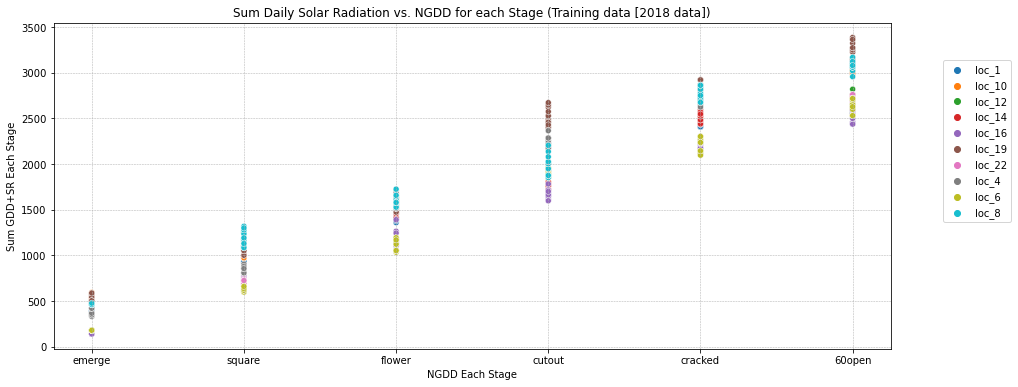

In [529]:
stage_tupp_opt = []

fig,ax = plt.subplots(1,figsize=(15,6))

sns.scatterplot(y='gdd_cum_needed',x='growth stage',hue='loc_id',
              data=train_data,ax=ax)
ax.set_title("Sum Daily Solar Radiation vs. NGDD for each Stage (Training data [2018 data])")

ax.set_ylabel("Sum GDD+SR Each Stage")
ax.legend(bbox_to_anchor=(0.65, 0, 0.5, 0.9))
ax.set_xlabel("NGDD Each Stage")

plt.grid(linestyle='--',linewidth=0.5)
plt.show()

In [530]:
# Separate training data from grwoth data
train_data = growth_pd[(growth_pd['test_train']==1)].copy()

In [531]:
thresh_df = train_data.groupby(['cultivar','growth stage']).mean().reset_index()\
    .sort_values(by=['cultivar','stage_num'])

gdd_thres_train = thresh_df[['cultivar','growth stage','gdd_cum_needed','gdd_stage_needed']]\
                                    .round(2).rename(columns={'gdd_cum_needed':'seas_to_date_thresh',
                                                                 'gdd_stage_needed':'stage_only_thresh'})

gdd_sr_thres_train = thresh_df[['cultivar','growth stage','gdd+srad_seas_to_date','gdd+srad_stage_only']]\
                                    .round(2).rename(columns={'gdd+srad_seas_to_date':'seas_to_date_thresh',
                                                                 'gdd+srad_stage_only':'stage_only_thresh'})

gdd_thres_train['stage_num'] = gdd_thres_train['growth stage'].map(stage_dict)
gdd_sr_thres_train['stage_num'] = gdd_sr_thres_train['growth stage'].map(stage_dict)

display(gdd_thres_train)
display(gdd_sr_thres_train)

,cultivar,growth stage,seas_to_date_thresh,stage_only_thresh,stage_num
3,DP 1612 B2XF,emerge,382.12,382.12,1
5,DP 1612 B2XF,square,912.13,536.00,2
4,DP 1612 B2XF,flower,1393.97,481.83,3
2,DP 1612 B2XF,cutout,1945.94,545.33,4
1,DP 1612 B2XF,cracked,2491.72,545.78,5
0,DP 1612 B2XF,60open,2780.02,304.16,6
9,DP 1646 B2XF,emerge,376.85,376.85,1
11,DP 1646 B2XF,square,934.90,563.87,2
10,DP 1646 B2XF,flower,1409.27,474.37,3
8,DP 1646 B2XF,cutout,1985.25,562.99,4


,cultivar,growth stage,seas_to_date_thresh,stage_only_thresh,stage_num
3,DP 1612 B2XF,emerge,624.06,624.06,1
5,DP 1612 B2XF,square,1248.50,628.30,2
4,DP 1612 B2XF,flower,1797.91,549.41,3
2,DP 1612 B2XF,cutout,2422.13,617.59,4
1,DP 1612 B2XF,cracked,3038.43,616.30,5
0,DP 1612 B2XF,60open,3364.23,341.66,6
9,DP 1646 B2XF,emerge,617.92,617.92,1
11,DP 1646 B2XF,square,1274.46,660.20,2
10,DP 1646 B2XF,flower,1815.80,541.34,3
8,DP 1646 B2XF,cutout,2466.27,636.74,4


In [532]:
train_data.reset_index(inplace=True)

In [535]:
# Do GDD+SR from plant date
vald_df = getPredObs_DaysToStage(gdd_sr_thres_train,growth_pd[growth_pd['test_train']==0].reset_index(),
                                 wxdf_copy,'from_plant','gdd+sr')
print("From Plant Date [GDD + SR]")
display(vald_df.groupby(['cultivar','stage_num'])[['Obs-Pred']].describe())

# Do GDD+SR - for each stage individually
each_val_df = getPredObs_DaysToStage(gdd_sr_thres_train,growth_pd[growth_pd['test_train']==0].reset_index(),
                                     wxdf_copy,'each','gdd+sr')
print("From Previous Stage [GDD + SR]")
display(each_val_df.groupby(['cultivar','stage_num'])[['Obs-Pred']].describe())

From Plant Date [GDD + SR]


Obs-Pred                                           \
                          count       mean        std   min    25%   50%   
cultivar     stage_num                                                     
DP 1612 B2XF 1             48.0 -28.395833   8.794920 -48.0 -33.00 -26.0   
             2             48.0 -21.437500   9.218174 -38.0 -25.00 -21.0   
             3             48.0 -23.145833   8.612187 -38.0 -29.00 -24.5   
             4             48.0 -25.062500   9.253881 -42.0 -34.25 -23.0   
             5             36.0 -21.805556  11.834138 -44.0 -28.00 -24.0   
             6             28.0 -33.357143  32.641957 -99.0 -46.00 -27.0   
DP 1646 B2XF 1             48.0 -27.645833   8.674957 -47.0 -32.25 -26.0   
             2             48.0 -18.729167  10.944229 -39.0 -24.25 -18.5   
             3             48.0 -20.333333   9.072599 -34.0 -28.00 -22.5   
             4             48.0 -24.500000   8.805221 -42.0 -30.00 -24.5   
             5             36.0 -22.472222  14.245774 -46.0 -28.25 -25.0   
             6             24.0 -29.166667  26.333425 -66.0 -56.00 -28.0   
DP 1851 B3XF 1             48.0 -28.375000   9.124727 -49.0 -31.25 -27.0   
             2             48.0 -19.895833  10.121054 -41.0 -25.00 -19.5   
             3             48.0 -21.812500   8.584142 -36.0 -28.00 -24.0   
             4             48.0 -24.625000   9.712078 -42.0 -31.25 -25.5   
             5             36.0 -24.611111  17.297857 -56.0 -30.00 -25.0   
             6             24.0 -35.708333  34.157537 -82.0 -78.00 -28.5   

                                     
                          75%   max  
cultivar     stage_num               
DP 1612 B2XF 1         -22.75 -16.0  
             2         -17.00   0.0  
             3         -15.50  -9.0  
             4         -19.00  -8.0  
             5         -11.25  -2.0  
             6           1.00   5.0  
DP 1646 B2XF 1         -22.75 -14.0  
             2         -11.00   3.0  
             3         -12.75  -4.0  
             4         -19.50  -9.0  
             5         -13.00   8.0  
             6           1.00   3.0  
DP 1851 B3XF 1         -23.75 -12.0  
             2         -14.00   1.0  
             3         -15.50  -5.0  
             4         -17.25  -7.0  
             5         -13.75   7.0  
             6           1.00   4.0

From Previous Stage [GDD + SR]


Obs-Pred                                           \
                          count       mean        std   min    25%   50%   
cultivar     stage_num                                                     
DP 1612 B2XF 1             48.0 -28.395833   8.794920 -48.0 -33.00 -26.0   
             2             48.0   0.395833   7.186689 -13.0  -3.25   1.0   
             3             48.0  -2.750000   5.529418 -11.0  -6.00  -4.0   
             4             48.0  -1.375000   6.609551 -11.0  -6.00  -4.0   
             5             48.0   3.229167   6.408902  -9.0  -1.00   3.0   
             6             48.0   0.791667   7.786946 -37.0  -3.00   0.0   
DP 1646 B2XF 1             48.0 -27.645833   8.674957 -47.0 -32.25 -26.0   
             2             48.0   2.208333   8.751798 -15.0  -5.00   3.0   
             3             48.0  -2.375000   5.314072 -11.0  -6.00  -2.0   
             4             48.0  -2.812500   7.436701 -12.0  -9.00  -4.0   
             5             48.0   2.812500   7.969773 -10.0  -2.00   1.0   
             6             47.0  -1.553191  11.046952 -54.0  -5.50  -2.0   
DP 1851 B3XF 1             48.0 -28.375000   9.124727 -49.0 -31.25 -27.0   
             2             48.0   1.854167   7.965323 -17.0  -3.00   3.0   
             3             48.0  -2.750000   4.817963 -10.0  -7.00  -3.0   
             4             48.0  -1.187500   7.505051 -11.0  -7.00  -2.5   
             5             48.0   3.354167   8.779787 -10.0  -2.00   3.0   
             6             46.0  -2.630435  11.193964 -40.0  -7.75  -3.0   

                                     
                          75%   max  
cultivar     stage_num               
DP 1612 B2XF 1         -22.75 -16.0  
             2           4.25  17.0  
             3           0.00  11.0  
             4           3.00  16.0  
             5           6.25  16.0  
             6           5.25  15.0  
DP 1646 B2XF 1         -22.75 -14.0  
             2          10.00  18.0  
             3           1.00  10.0  
             4           1.25  17.0  
             5           7.00  26.0  
             6           3.00  14.0  
DP 1851 B3XF 1         -23.75 -12.0  
             2           7.00  17.0  
             3           0.00  11.0  
             4           2.00  18.0  
             5           7.25  25.0  
             6           5.75  14.0

In [536]:
# Do GDD only from plant date
gdd_vald_df = getPredObs_DaysToStage(gdd_thres_train,growth_pd[growth_pd['test_train']==0].reset_index(),
                                 wxdf_copy,'from_plant','gdd')
print("From Plant Date [GDD Only]")
display(gdd_vald_df.groupby(['cultivar','stage_num'])['Obs-Pred'].describe())

# Go GDD only - for each stage individually
gdd_each_val_df = getPredObs_DaysToStage(gdd_thres_train,growth_pd[growth_pd['test_train']==0].reset_index(),
                                     wxdf_copy,'each','gdd')
print("From Previous Stage [GDD Only]")
display(gdd_each_val_df.groupby(['cultivar','stage_num'])['Obs-Pred'].describe())

From Plant Date [GDD Only]


count       mean        std   min    25%   50%    75%  \
cultivar     stage_num                                                          
DP 1612 B2XF 1           48.0 -21.645833   9.850995 -45.0 -24.25 -19.0 -15.75   
             2           48.0 -14.104167  10.441814 -34.0 -19.50 -13.0  -8.00   
             3           48.0 -16.729167   9.190049 -34.0 -21.00 -17.0  -9.00   
             4           48.0 -18.312500   8.863399 -34.0 -27.00 -16.0 -12.00   
             5           40.0 -16.400000  12.739601 -39.0 -25.00 -17.5  -6.50   
             6           28.0 -11.928571  19.269874 -48.0 -20.25 -16.0   9.25   
DP 1646 B2XF 1           48.0 -20.479167   9.758770 -44.0 -22.75 -19.0 -14.00   
             2           48.0 -11.729167  12.077303 -33.0 -19.25 -10.0  -2.00   
             3           48.0 -13.666667   9.846337 -32.0 -20.00 -15.0  -5.00   
             4           48.0 -17.583333   8.261249 -33.0 -23.00 -16.0 -12.00   
             5           36.0 -14.472222  14.349686 -40.0 -24.00 -16.5  -4.75   
             6           24.0 -10.125000  16.313005 -34.0 -22.00 -11.0   8.25   
DP 1851 B3XF 1           48.0 -21.625000  10.165911 -46.0 -23.25 -19.0 -15.00   
             2           48.0 -12.895833  11.411528 -36.0 -19.50 -10.5  -6.00   
             3           48.0 -15.229167   9.212017 -32.0 -20.00 -16.5  -8.75   
             4           48.0 -17.791667   8.778500 -33.0 -24.25 -17.0 -11.00   
             5           36.0 -14.277778  15.093255 -43.0 -23.50 -16.0  -6.00   
             6           24.0 -19.708333  35.475012 -95.0 -23.00 -12.0   8.25   

                         max  
cultivar     stage_num        
DP 1612 B2XF 1          -9.0  
             2           8.0  
             3          -2.0  
             4          -4.0  
             5           7.0  
             6          12.0  
DP 1646 B2XF 1          -7.0  
             2          10.0  
             3           3.0  
             4          -4.0  
             5          17.0  
             6          10.0  
DP 1851 B3XF 1          -6.0  
             2           8.0  
             3           2.0  
             4          -3.0  
             5          17.0  
             6          12.0

From Previous Stage [GDD Only]


count       mean        std   min    25%   50%    75%  \
cultivar     stage_num                                                          
DP 1612 B2XF 1           48.0 -21.645833   9.850995 -45.0 -24.25 -19.0 -15.75   
             2           48.0  -0.020833   8.117461 -15.0  -3.75   1.0   4.25   
             3           48.0  -2.937500   5.392691 -11.0  -6.00  -4.0  -1.00   
             4           48.0  -1.416667   6.286877 -11.0  -6.00  -3.5   3.00   
             5           48.0   3.187500   6.383677  -8.0  -1.00   3.0   6.25   
             6           47.0   1.638298   5.604445  -7.0  -3.00   0.0   5.50   
DP 1646 B2XF 1           48.0 -20.479167   9.758770 -44.0 -22.75 -19.0 -14.00   
             2           48.0   1.708333   9.675497 -17.0  -5.00   3.0   9.25   
             3           48.0  -2.458333   5.023173 -11.0  -6.00  -2.0   1.00   
             4           48.0  -2.979167   7.200738 -12.0  -9.00  -4.0   0.25   
             5           48.0   2.979167   8.051667 -10.0  -2.00   0.5   7.00   
             6           45.0   0.022222   7.240947 -12.0  -5.00  -2.0   3.00   
DP 1851 B3XF 1           48.0 -21.625000  10.165911 -46.0 -23.25 -19.0 -15.00   
             2           48.0   1.479167   8.958509 -19.0  -3.50   3.5   7.25   
             3           48.0  -2.854167   4.580205 -10.0  -6.00  -3.0  -1.00   
             4           48.0  -1.208333   7.374361 -10.0  -7.00  -2.5   2.00   
             5           48.0   3.500000   8.996453 -11.0  -2.00   3.0   8.00   
             6           43.0  -2.441860  14.115682 -76.0  -6.50  -3.0   6.50   

                         max  
cultivar     stage_num        
DP 1612 B2XF 1          -9.0  
             2          17.0  
             3          10.0  
             4          14.0  
             5          16.0  
             6          15.0  
DP 1646 B2XF 1          -7.0  
             2          19.0  
             3           9.0  
             4          16.0  
             5          27.0  
             6          14.0  
DP 1851 B3XF 1          -6.0  
             2          17.0  
             3          10.0  
             4          17.0  
             5          26.0  
             6          14.0